In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [ ]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0*2, 6.0*2]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Introduction

Here I look at the volume of the sub-space in which the signal/background is high enough to minimize the statistics + systematics errors.

Hypothesis : 
- Data augmentation (& other methods) fails because it increase the selected volume. At test time this increase too much the number of selected background events. 


**Remaining work**:
- FIX the NaN issue
- Test the code. Write something to prove that it is correct
- Correlation between sigma mu and volume ?
- Redaction de tout ça au propre.

In [1]:
from problem.workflow import pprint

# Data

In [2]:
from problem.higgs_geant import load_data

In [3]:
print('Loading data ...')
data, _ = load_data()
print('Done !')

In [4]:
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1.0
1,160.937,68.768,103.235,48.146,0.00,0.000,0.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,0.000,0.00,0.000,46.226,0.681042,0.0
2,0.000,162.172,125.953,35.635,0.00,0.000,0.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,0.000,0.00,0.000,44.251,0.715742,0.0
3,143.905,81.417,80.943,0.414,0.00,0.000,0.000,3.310,0.414,75.968,...,0,0.000,0.000,0.000,0.000,0.00,0.000,-0.000,1.660654,0.0
4,175.864,16.915,134.805,16.405,0.00,0.000,0.000,3.891,16.405,57.983,...,0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.904263,0.0


# Load models

In [5]:
from problem.higgs_geant import get_save_directory
from problem.higgs_geant import skew
from problem.higgs_geant import tangent
from problem.higgs_geant import get_cv_iter


In [6]:
def load_models(model_class, *args, **kwargs):
    models = []
    cv_iter = get_cv_iter(data, data['Label'])
    n_cv = len(cv_iter)
    pprint('Loading', n_cv, model_class.__name__)
    for i in range(n_cv):
        model = model_class(*args, **kwargs)
        save_directory = get_save_directory()
        model_name = '{}-{}'.format(model.get_name(), i)
        path = os.path.join(save_directory, model_name)
        model.load(path)
        models.append(model)
    return models

In [7]:
from models.higgsml import NeuralNetModel
from models.higgsml import AugmentedNeuralNetModel
from models.higgsml import TangentPropModel
from models.higgsml import AugmentedTangentPropModel
from models.higgsml import PivotModel


In [ ]:
NN_models = load_models(NeuralNetModel, n_steps=10000, batch_size=1024, cuda=True)


In [ ]:
ANN_models = load_models(AugmentedNeuralNetModel, skewing_function=skew, n_augment=5,
                         batch_size=1024, n_steps=10000, width=0.03, cuda=True)


In [ ]:
TP_models = load_models(TangentPropModel, skewing_function=skew, trade_off=0.01, 
                        batch_size=1024, n_steps=10000, cuda=True )


In [ ]:
PAN_models = load_models(PivotModel, skewing_function=skew, batch_size=1024, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=0.01, trade_off=1.0, cuda=True)


# I need the model's prediction

- Do I need the data for each TES ?
- I need the decision function & a n-D box
- Where does the n-D box comes from ?
    - min and max on the combined dataset at -5% and +5%
    - yep. It seems to be large enough to avoid missing sub-spaces.
    - But I think it is too pessimistic. I can probably do better. But let's leave that for later.
    
- Train--Test split : Do I need it ?
    - It seems useless. I need a box. I don't care if it comes from training or testing data the box is not part of the learning process.
    - Let's take it all to make sure the box is large enough.

In [ ]:
def generate_uniform_samples(n_dim, n_samples, min_array, max_array):
    import ghalton
    gen = ghalton.Halton(n_dim)
    points = np.array( gen.get(int(n_samples)) )
    points = points * ( max_array - min_array ) + min_array
    return points


In [ ]:
def test_submission(data, models, threshold, max_TES=1.05, min_TES=0.95, n_samples=10000):
    volumes = []
    data_max = skewing_function(data, sysTauEnergyScale=max_TES)
    data_min = skewing_function(data, sysTauEnergyScale=min_TES)
    data_mix = pd.concat([data_max, data_min])
    
    X_mix, y_mix, W_mix = split_data_label_weights(data_mix)
    n_dim = X_mix.shape[1]
    for model in models:
        proba = model.predict_proba(X_mix)
        idx = np.where(proba[:, 1] > threshold)
        X_selected = X_mix.iloc[idx]
#        min_array = X_selected.min(axis=0).values.reshape(1, -1)
#        max_array = X_selected.max(axis=0).values.reshape(1, -1)
        # FIXME : max_array can be NaN with Tangent Prop : What The FUCK ?
        min_array = np.nanmin(X_selected.values, axis=0).reshape(1, -1)
        max_array = np.nanmax(X_selected.values, axis=0).reshape(1, -1)
        
        samples = generate_uniform_samples(n_dim, n_samples, min_array, max_array)
        count = np.sum( model.predict_proba(samples)[:, 1] > threshold )
        
        vol = np.prod(max_array - min_array)
        vol = ( vol * count ) / n_samples
        volumes.append(vol)
    return volumes


In [ ]:
NN_volumes = test_submission(data, NN_models, 0.9)

In [ ]:
ANN_volumes = test_submission(data, ANN_models, 0.9)

In [ ]:
TP_volumes = test_submission(data, TP_models, 0.9)

In [ ]:
PAN_volumes = test_submission(data, PAN_models, 0.9)

# Compare volumes


What I need to do is to compare the volume and the score and see if there is a correlation between them.

Hypothesis :
- There should be a negative correlation. The more volume the more background are selected which decrease the performances.

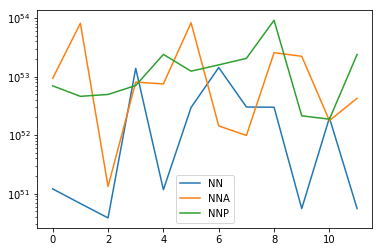

In [64]:
plt.plot(NN_volumes, label='NN')
plt.plot(NNA_volumes, label='NNA')
plt.plot(NNDA_volumes, label='NNP')
#plt.plot(TP_volumes, label='TP')
#plt.plot(PAN_volumes, label='PAN')
plt.yscale('log')
plt.legend()
plt.show()

# Quasi-Monte Carlo

In [ ]:
def generate_uniform_samples(n_dim, n_samples, min_array, max_array):
    import ghalton
    gen = ghalton.Halton(n_dim)
    points = np.array( gen.get(int(n_samples)) )
    points = points * ( max_array - min_array ) + min_array
    return points
    
def quasi_monte_carlo_volume(n_dim, n_samples, min_array, max_array, question_fun):
    samples = generate_uniform_samples(n_dim, n_samples, min_array, max_array)
    count = np.sum( question_fun(samples) )
    volume = np.prod(max_array - min_array)
    volume = ( volume * count ) / n_samples
    return volume, count
